In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

2024-04-11 13:08:57.188488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 13:08:57.188608: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 13:08:57.308771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check if GPU is available
print("GPU Available:", tf.test.is_gpu_available())

# Check if CUDA is available
print("CUDA Available:", tf.test.is_built_with_cuda())

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

GPU Available: True
CUDA Available: True
TensorFlow version: 2.15.0


In [3]:
# Define paths to parent directory containing train folders and the CSV file
parent_dir = '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/'
csv_file = '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/ISIC2018_Task3_Training_LesionGroupings_WithoutDuplicates_Merged.csv'
csv_file_test = '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/ISIC2018_Task3_Testing_GroundTruth.csv'

In [4]:
# Load class labels and image filenames from the CSV file for the training set
class_labels_df = pd.read_csv(csv_file)
image_filenames = []

for i in range(len(class_labels_df)):
    image_filenames.append(f"train{int(class_labels_df.iloc[i].fold_number)}/{class_labels_df.iloc[i].image}.jpg")

labels = class_labels_df[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values

In [5]:
# Load class labels and image filenames from the CSV file for the testing set
class_labels_df_test = pd.read_csv(csv_file_test)
image_filenames_test = []

for i in range(len(class_labels_df_test)):
    image_filenames_test.append(f"test/{class_labels_df_test.iloc[i].image}.jpg")

labels_test = class_labels_df_test[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].values

In [6]:
class_labels_df

image    lesion_id            diagnosis_confirm_type  MEL   NV  \
0     ISIC_0028498  HAM_0000000                    histopathology  0.0  1.0   
1     ISIC_0027859  HAM_0000001                    histopathology  0.0  0.0   
2     ISIC_0034246  HAM_0000002                    histopathology  1.0  0.0   
3     ISIC_0027886  HAM_0000003  serial imaging showing no change  0.0  1.0   
4     ISIC_0024645  HAM_0000004  serial imaging showing no change  0.0  1.0   
...            ...          ...                               ...  ...  ...   
7465  ISIC_0026322  HAM_0007624  serial imaging showing no change  0.0  1.0   
7466  ISIC_0033736  HAM_0007625                    histopathology  0.0  0.0   
7467  ISIC_0031300  HAM_0007626  serial imaging showing no change  0.0  1.0   
7468  ISIC_0029820  HAM_0007627                    histopathology  0.0  0.0   
7469  ISIC_0027059  HAM_0007628  serial imaging showing no change  0.0  1.0   

      BCC  AKIEC  BKL   DF  VASC  fold_number  
0     0.0    0.0  0.0  0.0   0.0          4.0  
1     0.0    0.0  1.0  0.0   0.0          7.0  
2     0.0    0.0  0.0  0.0   0.0          8.0  
3     0.0    0.0  0.0  0.0   0.0         10.0  
4     0.0    0.0  0.0  0.0   0.0          9.0  
...   ...    ...  ...  ...   ...          ...  
7465  0.0    0.0  0.0  0.0   0.0          0.0  
7466  0.0    0.0  1.0  0.0   0.0          2.0  
7467  0.0    0.0  0.0  0.0   0.0          9.0  
7468  1.0    0.0  0.0  0.0   0.0          5.0  
7469  0.0    0.0  0.0  0.0   0.0          4.0  

[7470 rows x 11 columns]

In [7]:
class_labels_df_test

image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0     ISIC_0034524  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1     ISIC_0034525  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2     ISIC_0034526  0.0  0.0  0.0    0.0  1.0  0.0   0.0
3     ISIC_0034527  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4     ISIC_0034528  0.0  1.0  0.0    0.0  0.0  0.0   0.0
...            ...  ...  ...  ...    ...  ...  ...   ...
1507  ISIC_0036060  0.0  0.0  0.0    0.0  1.0  0.0   0.0
1508  ISIC_0036061  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1509  ISIC_0036062  0.0  0.0  0.0    1.0  0.0  0.0   0.0
1510  ISIC_0036063  0.0  0.0  0.0    0.0  1.0  0.0   0.0
1511  ISIC_0036064  0.0  0.0  1.0    0.0  0.0  0.0   0.0

[1512 rows x 8 columns]

In [8]:
image_filenames

['train4/ISIC_0028498.jpg',
 'train7/ISIC_0027859.jpg',
 'train8/ISIC_0034246.jpg',
 'train10/ISIC_0027886.jpg',
 'train9/ISIC_0024645.jpg',
 'train7/ISIC_0030591.jpg',
 'train4/ISIC_0034162.jpg',
 'train9/ISIC_0033879.jpg',
 'train2/ISIC_0029868.jpg',
 'train13/ISIC_0029779.jpg',
 'train3/ISIC_0027730.jpg',
 'train4/ISIC_0024678.jpg',
 'train1/ISIC_0030085.jpg',
 'train4/ISIC_0024655.jpg',
 'train14/ISIC_0031366.jpg',
 'train12/ISIC_0031453.jpg',
 'train14/ISIC_0029142.jpg',
 'train9/ISIC_0025894.jpg',
 'train10/ISIC_0032122.jpg',
 'train10/ISIC_0025396.jpg',
 'train10/ISIC_0031922.jpg',
 'train8/ISIC_0026773.jpg',
 'train11/ISIC_0031377.jpg',
 'train8/ISIC_0026144.jpg',
 'train3/ISIC_0027141.jpg',
 'train2/ISIC_0028271.jpg',
 'train0/ISIC_0029325.jpg',
 'train7/ISIC_0030509.jpg',
 'train12/ISIC_0029752.jpg',
 'train8/ISIC_0026815.jpg',
 'train11/ISIC_0031383.jpg',
 'train12/ISIC_0028177.jpg',
 'train6/ISIC_0032291.jpg',
 'train5/ISIC_0031861.jpg',
 'train7/ISIC_0032411.jpg',
 'train6

In [9]:
image_filenames_test

['test/ISIC_0034524.jpg',
 'test/ISIC_0034525.jpg',
 'test/ISIC_0034526.jpg',
 'test/ISIC_0034527.jpg',
 'test/ISIC_0034528.jpg',
 'test/ISIC_0034529.jpg',
 'test/ISIC_0034530.jpg',
 'test/ISIC_0034531.jpg',
 'test/ISIC_0034532.jpg',
 'test/ISIC_0034533.jpg',
 'test/ISIC_0034534.jpg',
 'test/ISIC_0034535.jpg',
 'test/ISIC_0034536.jpg',
 'test/ISIC_0034537.jpg',
 'test/ISIC_0034538.jpg',
 'test/ISIC_0034539.jpg',
 'test/ISIC_0034540.jpg',
 'test/ISIC_0034541.jpg',
 'test/ISIC_0034542.jpg',
 'test/ISIC_0034543.jpg',
 'test/ISIC_0034544.jpg',
 'test/ISIC_0034545.jpg',
 'test/ISIC_0034546.jpg',
 'test/ISIC_0034547.jpg',
 'test/ISIC_0034548.jpg',
 'test/ISIC_0034549.jpg',
 'test/ISIC_0034551.jpg',
 'test/ISIC_0034552.jpg',
 'test/ISIC_0034553.jpg',
 'test/ISIC_0034554.jpg',
 'test/ISIC_0034555.jpg',
 'test/ISIC_0034556.jpg',
 'test/ISIC_0034557.jpg',
 'test/ISIC_0034558.jpg',
 'test/ISIC_0034559.jpg',
 'test/ISIC_0034560.jpg',
 'test/ISIC_0034561.jpg',
 'test/ISIC_0034562.jpg',
 'test/ISIC_

In [10]:
labels[0], labels_test[0]

(array([0., 1., 0., 0., 0., 0., 0.]), array([0., 1., 0., 0., 0., 0., 0.]))

In [11]:
# Create list of paths to train directories
train_dirs = [os.path.join(parent_dir, f'train{i}') for i in range(15)]
train_dirs

['/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train0',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train1',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train2',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train3',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train4',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train5',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train6',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train7',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train8',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train9',
 '/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stra

In [12]:
# Initialize lists to store image paths and labels for the training set
image_paths = []
image_labels = []

for idx, image_filename in enumerate(image_filenames):
    # Construct full path to image file
    image_path = os.path.join(parent_dir, image_filename)
    
    # Check if image file exists
    if os.path.exists(image_path):
        image_paths.append(image_path)
        image_labels.append(labels[idx])

# Create TensorFlow Dataset from image paths and labels
train_dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))

In [13]:
# Initialize lists to store image paths and labels for the testing set
image_paths_test = []
image_labels_test = []

for idx, image_filename in enumerate(image_filenames_test):
    # Construct full path to image file
    image_path = os.path.join(parent_dir, image_filename)
    
    # Check if image file exists
    if os.path.exists(image_path):
        image_paths_test.append(image_path)
        image_labels_test.append(labels[idx])

# Create TensorFlow Dataset from image paths and labels
test_dataset = tf.data.Dataset.from_tensor_slices((image_paths_test, image_labels_test))

In [14]:
list(zip(image_paths[:10], image_labels[:10]))

[('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train4/ISIC_0028498.jpg',
  array([0., 1., 0., 0., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train7/ISIC_0027859.jpg',
  array([0., 0., 0., 0., 1., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train8/ISIC_0034246.jpg',
  array([1., 0., 0., 0., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train10/ISIC_0027886.jpg',
  array([0., 1., 0., 0., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train9/ISIC_0024645.jpg',
  array([0., 1., 0., 0., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/train7/ISIC_0030591.jpg',
  array([0., 0., 0., 1., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/t

In [15]:
list(zip(image_paths_test[:10], image_labels_test[:10]))

[('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test/ISIC_0034524.jpg',
  array([0., 1., 0., 0., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test/ISIC_0034525.jpg',
  array([0., 0., 0., 0., 1., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test/ISIC_0034526.jpg',
  array([1., 0., 0., 0., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test/ISIC_0034527.jpg',
  array([0., 1., 0., 0., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test/ISIC_0034528.jpg',
  array([0., 1., 0., 0., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test/ISIC_0034529.jpg',
  array([0., 0., 0., 1., 0., 0., 0.])),
 ('/kaggle/input/isic2018-7-5k-non-mv-384-jpg-stratified/stratified_jpg_384_inpainted/test/ISIC_0034

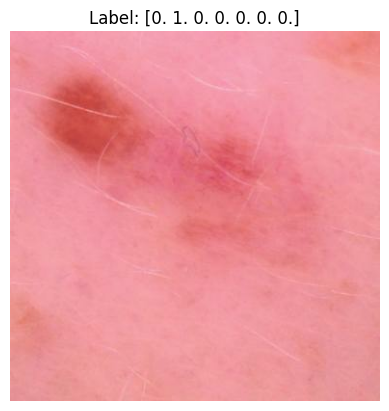

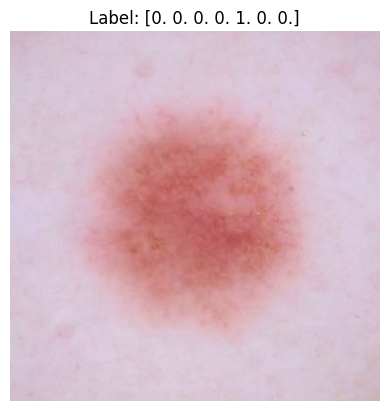

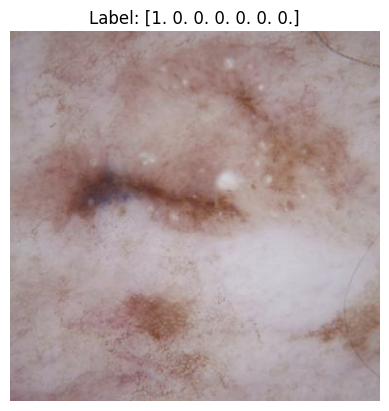

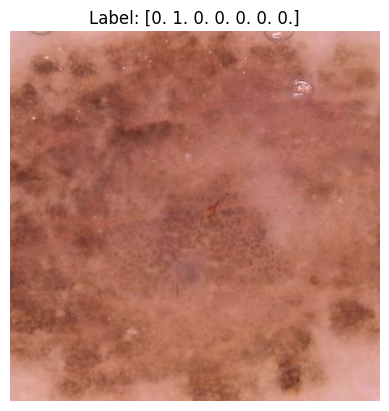

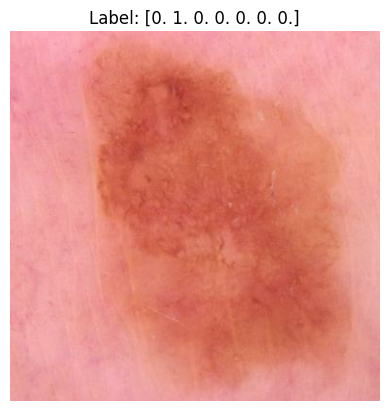

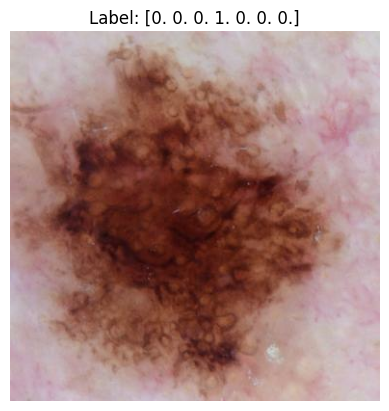

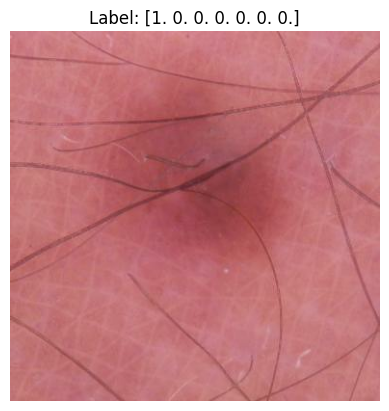

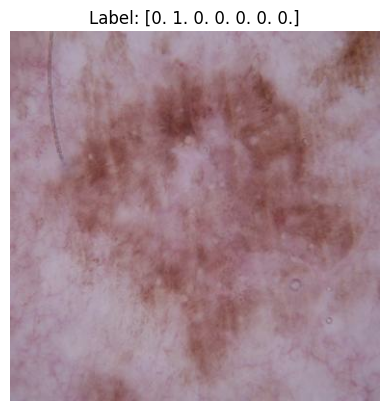

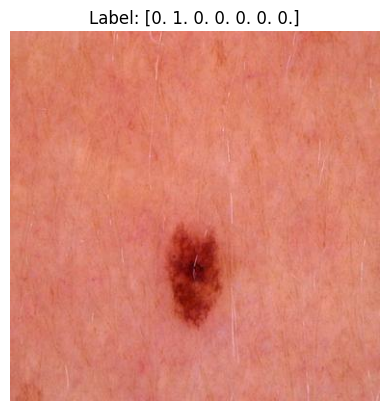

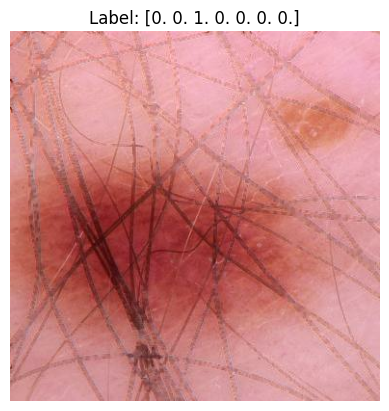

In [16]:
for image_path, label in test_dataset.take(10):
    # Read and decode image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Assuming JPEG images with 3 channels

    # Display image
    plt.imshow(img.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")
    plt.show()

In [17]:
# Function to load and preprocess images
def load_and_preprocess_image(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG image
    img = tf.image.resize(img, [224, 224])  # Resize image
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img, label

# Map the preprocessing function to the dataset
train_dataset = train_dataset.map(load_and_preprocess_image)

# Define batch size and shuffle the dataset
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(image_paths)).batch(batch_size)

# Print dataset information
print("Number of images:", len(image_paths))
print("Batch size:", batch_size)

Number of images: 7470
Batch size: 32


In [18]:
# Function to load and preprocess images for test dataset
def load_and_preprocess_image_test(filename, label):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)  # Decode JPEG image
    img = tf.image.resize(img, [224, 224])  # Resize image
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img, label

# Map the preprocessing function to the test dataset
test_dataset = test_dataset.map(load_and_preprocess_image_test)

# Define batch size for test dataset
test_batch_size = 32

# Shuffle and batch the test dataset (optional)
test_dataset = test_dataset.batch(test_batch_size)

# Print dataset information
print("Number of images in test dataset:", len(image_paths_test))
print("Test batch size:", test_batch_size)


Number of images in test dataset: 1512
Test batch size: 32


In [19]:
# Iterate over the first 5 batches of the dataset
for i, batch in enumerate(train_dataset.take(5)):
    batch_size = batch[0].shape[0]  # Get the size of the batch (number of images)
    image_size = batch[0].shape[1:
                                3]  # Get the size of each image
    tensor_shape = batch[0].shape  # Get the shape of the tensor
    
    print(f"Batch {i+1} - Size: {batch_size}, Image Size: {image_size}, Tensor Shape: {tensor_shape}")

Batch 1 - Size: 32, Image Size: (224, 224), Tensor Shape: (32, 224, 224, 3)
Batch 2 - Size: 32, Image Size: (224, 224), Tensor Shape: (32, 224, 224, 3)
Batch 3 - Size: 32, Image Size: (224, 224), Tensor Shape: (32, 224, 224, 3)
Batch 4 - Size: 32, Image Size: (224, 224), Tensor Shape: (32, 224, 224, 3)
Batch 5 - Size: 32, Image Size: (224, 224), Tensor Shape: (32, 224, 224, 3)


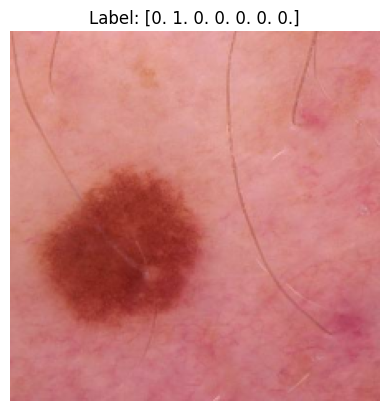

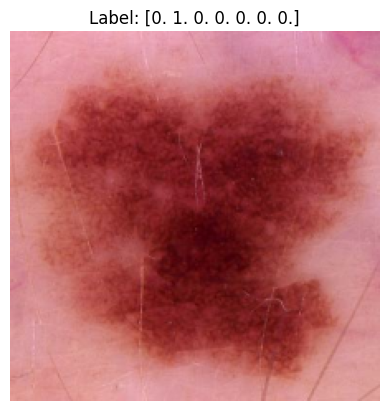

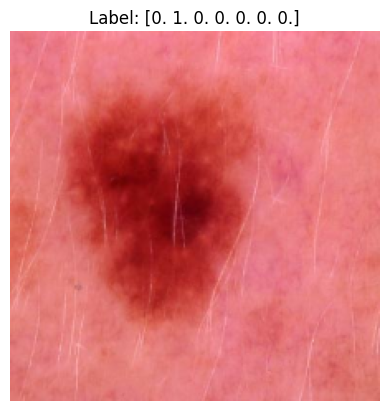

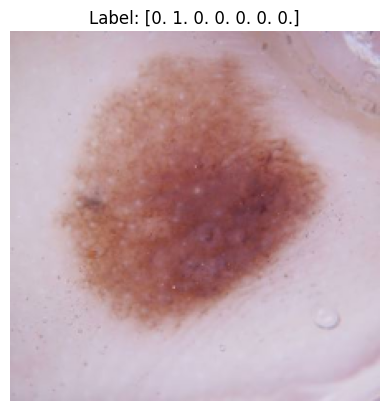

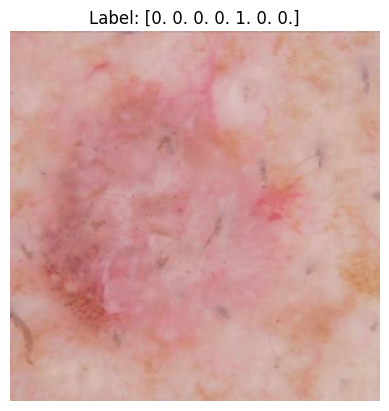

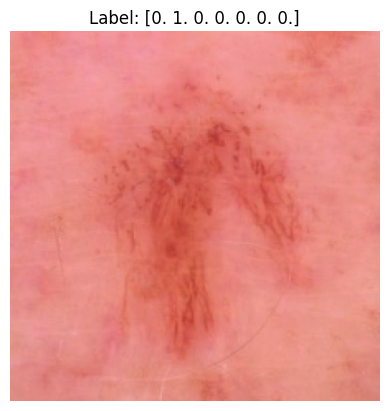

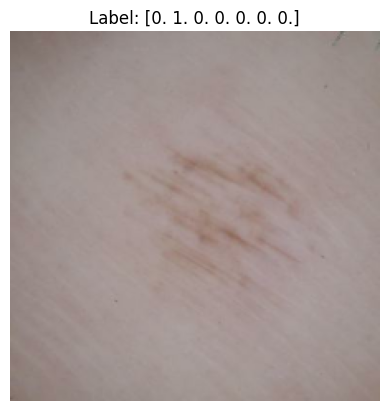

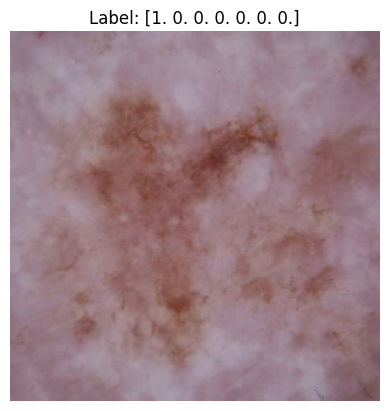

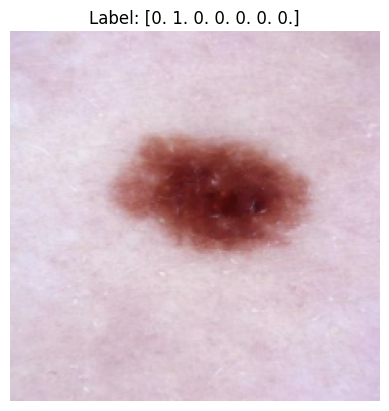

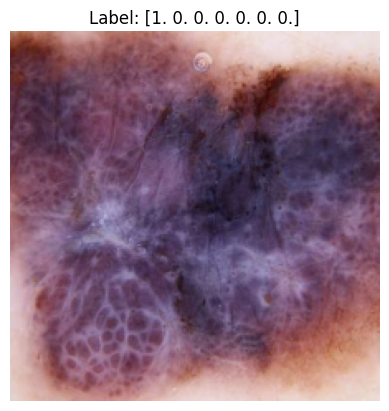

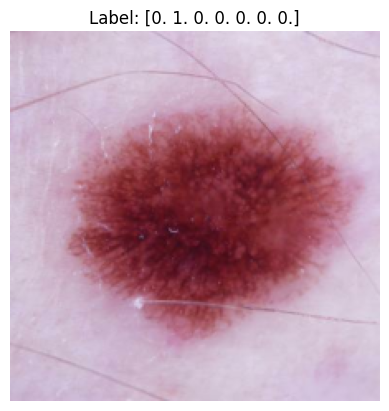

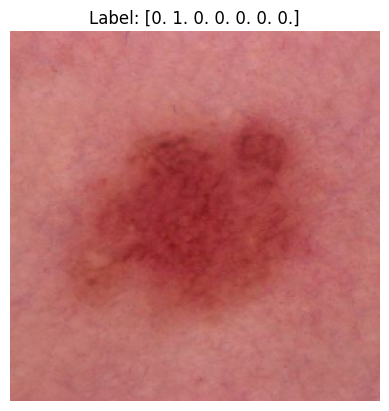

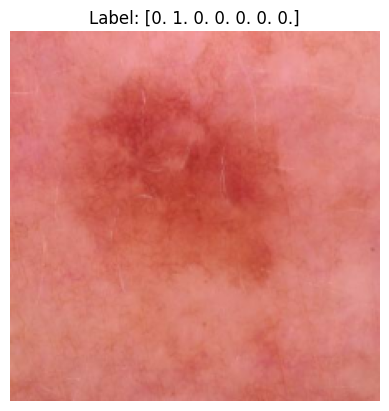

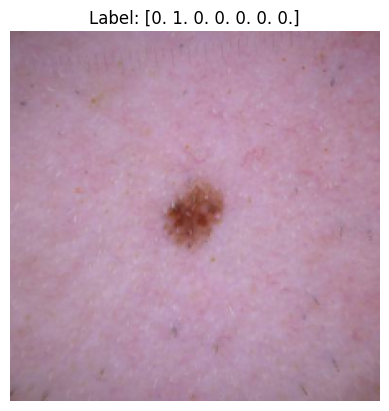

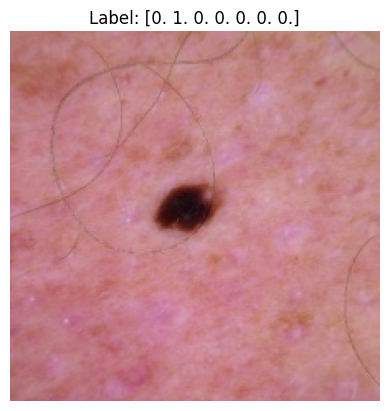

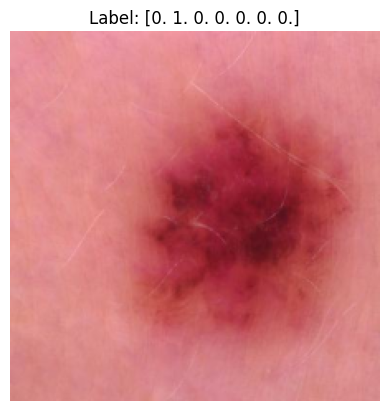

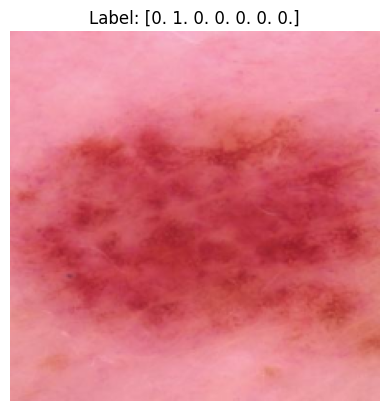

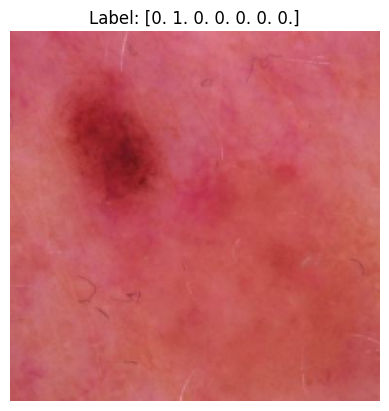

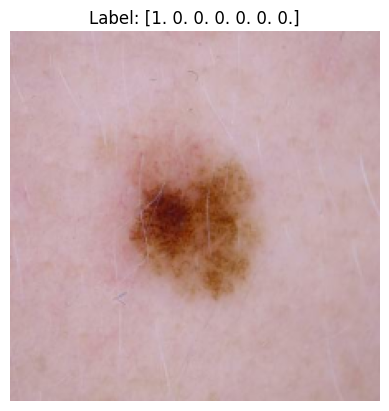

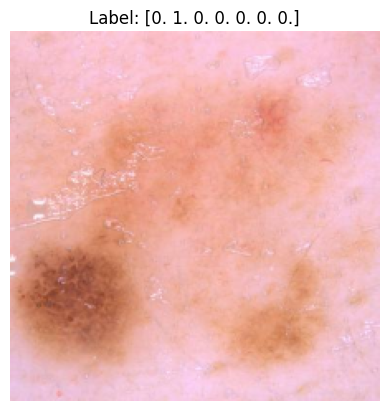

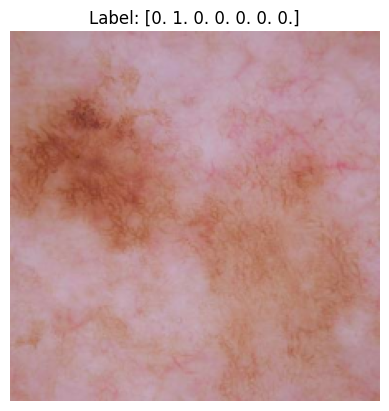

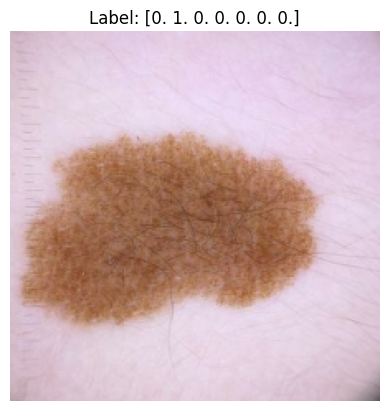

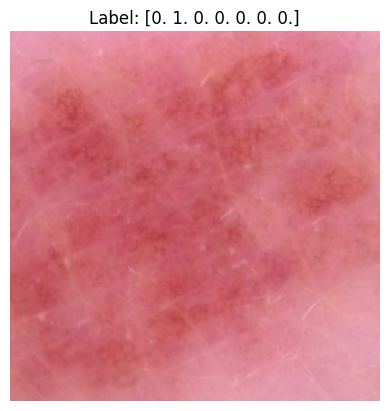

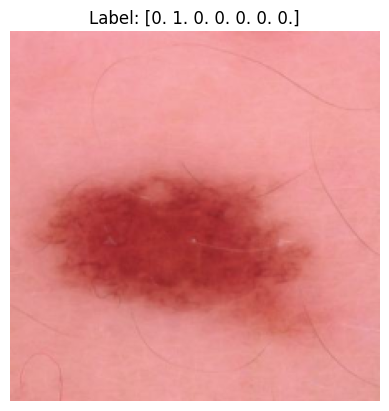

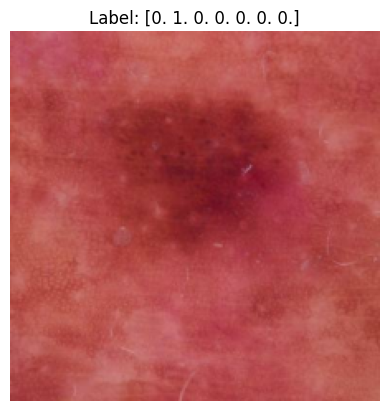

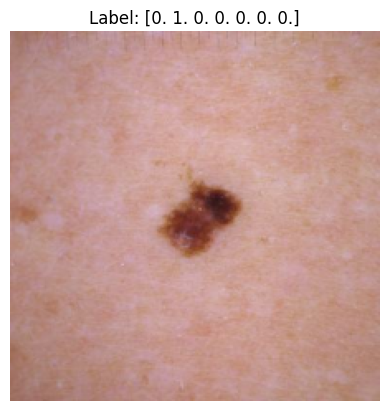

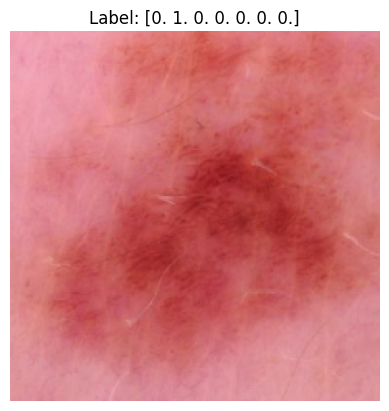

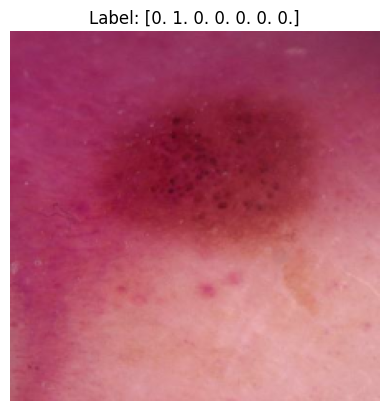

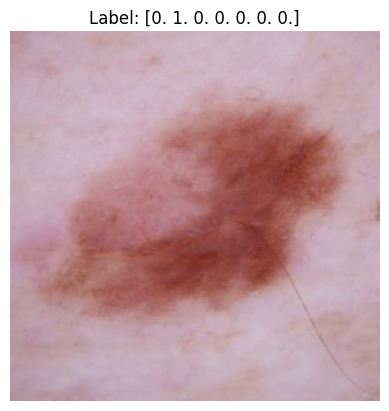

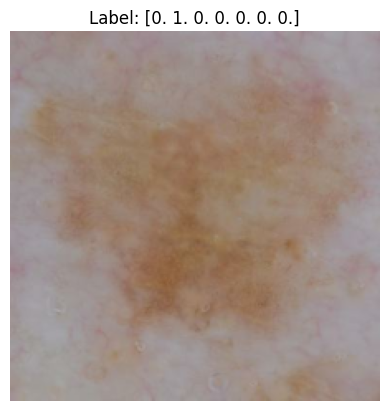

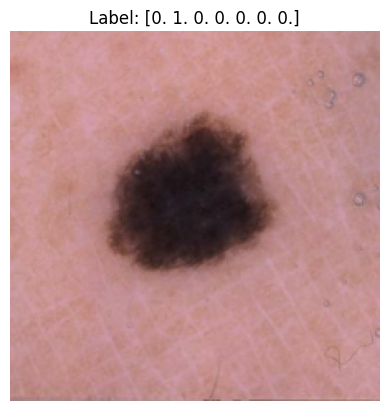

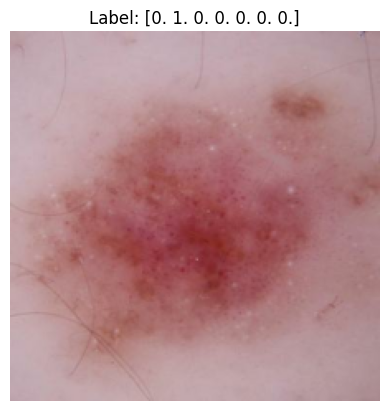

In [20]:
for batch in train_dataset:
    images = batch[0]  # Accessing images from the batch
    labels = batch[1]  # Accessing labels from the batch

    # Visualize images from the batch
    for i in range(len(images)):
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
        plt.show()

    # Break out of the loop after processing the first batch
    break

In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers.legacy import Adam

def identity_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x_skip = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def ResNet18_Without_Dilation(inputShape=(224,224,3),kernelSize=(3,3), num_classes=8):
    input_layer = layers.Input(shape=inputShape)

    x = layers.Conv2D(64, 7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1)
    x = identity_block(x, filters=64, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1)
    x = identity_block(x, filters=128, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1)
    x = identity_block(x, filters=256, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=512, kernel_size=3, stride=1)
    x = identity_block(x, filters=512, kernel_size=3)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)  # Adding a dense layer
    x = layers.Dropout(0.5)(x)  # Adding a dropout layer
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet18_with_dropout')
    return model

resnet18 = ResNet18_Without_Dilation(inputShape=(224, 224, 3), num_classes=7)

resnet18.summary()

Model: "resnet18_with_dropout"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 112, 112,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 112, 112,  │          0 │ batch_normalizat

 Total params: 11,328,455 (43.21 MB)

 Trainable params: 11,318,727 (43.18 MB)

 Non-trainable params: 9,728 (38.00 KB)

In [22]:
for image, label in train_dataset:
    print(image, label)
    break

tf.Tensor(
[[[[0.9621849  0.73473394 0.78179276]
   [0.9621849  0.73473394 0.78179276]
   [0.9621849  0.73473394 0.78179276]
   ...
   [0.9591037  0.7238096  0.7630253 ]
   [0.96816736 0.73287326 0.77208894]
   [0.9755702  0.7402761  0.7794918 ]]

  [[0.9647059  0.7372549  0.78431374]
   [0.9647059  0.7372549  0.78431374]
   [0.9647059  0.7372549  0.78431374]
   ...
   [0.95708287 0.72178876 0.76100445]
   [0.96358556 0.7282914  0.7675071 ]
   [0.9703081  0.735014   0.7742297 ]]

  [[0.96778715 0.7403362  0.787395  ]
   [0.96778715 0.7403362  0.787395  ]
   [0.96778715 0.7403362  0.787395  ]
   ...
   [0.9521009  0.71680677 0.75602245]
   [0.9557424  0.72044826 0.75966394]
   [0.96048415 0.72519004 0.7644057 ]]

  ...

  [[0.93333334 0.7372549  0.73333335]
   [0.93333334 0.7372549  0.73333335]
   [0.93333334 0.7372549  0.73333335]
   ...
   [0.932493   0.7403361  0.76386553]
   [0.92941177 0.7372549  0.7607843 ]
   [0.9285714  0.73641455 0.75994396]]

  [[0.93333334 0.7372549  0.733333

Epoch 1/50
Training Loss - Epoch 1: 0.5654252767562866
Training Accuracy - Epoch 1: 0.7232931852340698
Testing Loss - Epoch 1: 1.1311975717544556
Testing Accuracy - Epoch 1: 0.7261904761904762
Epoch 2/50
Training Loss - Epoch 2: 0.7086060643196106
Training Accuracy - Epoch 2: 0.7278447151184082
Testing Loss - Epoch 2: 0.7032875418663025
Testing Accuracy - Epoch 2: 0.7136243386243386
Epoch 3/50
Training Loss - Epoch 3: 0.3996352255344391
Training Accuracy - Epoch 3: 0.7132530212402344
Testing Loss - Epoch 3: 0.8363036513328552
Testing Accuracy - Epoch 3: 0.6256613756613757
Epoch 4/50
Training Loss - Epoch 4: 0.23610162734985352
Training Accuracy - Epoch 4: 0.7220883369445801
Testing Loss - Epoch 4: 0.6925705671310425
Testing Accuracy - Epoch 4: 0.6911375661375662
Epoch 5/50
Training Loss - Epoch 5: 0.6814786195755005
Training Accuracy - Epoch 5: 0.7412316203117371
Testing Loss - Epoch 5: 0.881952166557312
Testing Accuracy - Epoch 5: 0.6144179894179894
Epoch 6/50
Training Loss - Epoch 6:

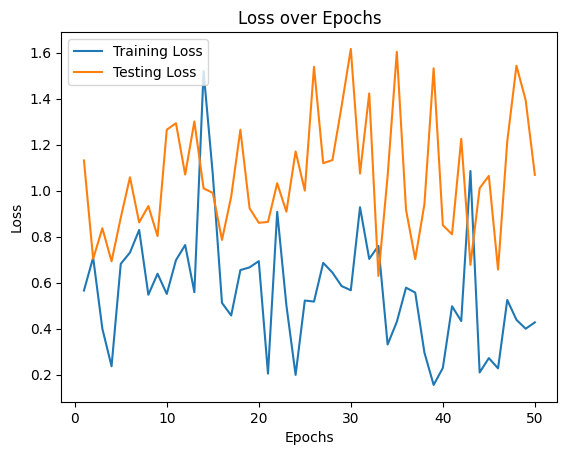

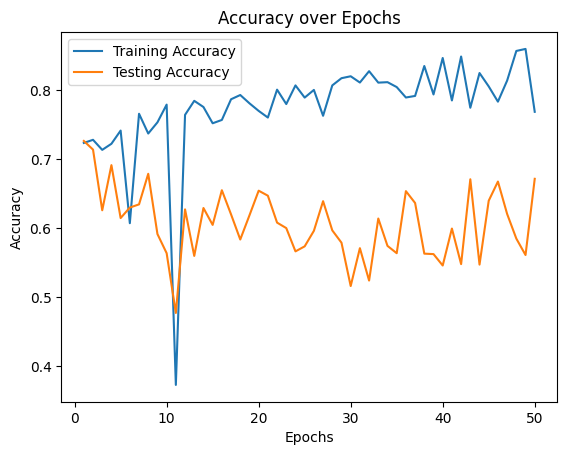

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Define optimizer
optimizer = tf.keras.optimizers.Adam()

epochs = 50

# Define lists to store training and testing metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training and testing loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training phase
    for images, one_hot_labels in train_dataset:
        with tf.GradientTape() as tape:
            predictions_train = resnet18(images, training=True)
            loss_train = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(one_hot_labels, predictions_train))
        
        gradients_train = tape.gradient(loss_train, resnet18.trainable_variables)
        optimizer.apply_gradients(zip(gradients_train, resnet18.trainable_variables))
    
    # Calculate training accuracy
    total_examples_train = 0
    correct_predictions_train = 0
    for images, one_hot_labels in train_dataset:
        predictions_train = resnet18(images, training=False)
        predicted_labels_train = tf.argmax(predictions_train, axis=1)
        true_labels_train = tf.argmax(one_hot_labels, axis=1)
        correct_predictions_train += tf.reduce_sum(tf.cast(tf.equal(predicted_labels_train, true_labels_train), dtype=tf.float32))
        total_examples_train += images.shape[0]
    
    train_loss = loss_train.numpy()
    train_accuracy = correct_predictions_train / total_examples_train
    print(f"Training Loss - Epoch {epoch+1}: {train_loss}")
    print(f"Training Accuracy - Epoch {epoch+1}: {train_accuracy}")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Testing phase
    true_labels_test_all = []
    predicted_labels_test_all = []
    for images, one_hot_labels in test_dataset:
        predictions_test = resnet18(images, training=False)
        predicted_labels_test = tf.argmax(predictions_test, axis=1)
        true_labels_test = tf.argmax(one_hot_labels, axis=1)
        true_labels_test_all.extend(true_labels_test.numpy())
        predicted_labels_test_all.extend(predicted_labels_test.numpy())
        loss_test = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(one_hot_labels, predictions_test))
    
    # Calculate testing accuracy
    total_examples_test = len(true_labels_test_all)
    correct_predictions_test = sum([1 for true, pred in zip(true_labels_test_all, predicted_labels_test_all) if true == pred])
    test_accuracy = correct_predictions_test / total_examples_test
    print(f"Testing Loss - Epoch {epoch+1}: {loss_test.numpy()}")
    print(f"Testing Accuracy - Epoch {epoch+1}: {test_accuracy}")
    test_losses.append(loss_test.numpy())
    test_accuracies.append(test_accuracy)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_test_all, predicted_labels_test_all, average='weighted', zero_division=1)
accuracy = accuracy_score(true_labels_test_all, predicted_labels_test_all)
metrics_dict = {'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Accuracy': accuracy}
print("Final Evaluation Metrics:")
print(metrics_dict)

# Plotting training and testing loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plotting training and testing accuracy
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


In [24]:
resnet_without_dilation_metrics = [precision, recall, f1, accuracy]

In [25]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def identity_block(x, filters, kernel_size=3, stride=1, dropout_rate=0.2):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def convolutional_block(x, filters, kernel_size=3, stride=1, dropout_rate=0.2):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x_skip = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)
    x_skip = layers.Dropout(dropout_rate)(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x

def dilated_convolutional_block(x, filters, kernel_size=3, stride=1, dropout_rate=0.2):
    x_skip = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', dilation_rate=(3,3))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x_skip = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x_skip)
    x_skip = layers.BatchNormalization()(x_skip)
    x_skip = layers.Dropout(dropout_rate)(x_skip)

    x = layers.add([x, x_skip])
    x = layers.Activation('relu')(x)
    return x    

def ResNet18_With_Dilation_And_Dropout(inputShape=(224,224,3),kernelSize=(3,3), num_classes=8):
    input_layer = layers.Input(shape=inputShape)

    x = layers.Conv2D(64, 7, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=64, kernel_size=3, stride=1, dropout_rate=0.2)
    x = identity_block(x, filters=64, kernel_size=3, dropout_rate=0.2)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=128, kernel_size=3, stride=1, dropout_rate=0.2)
    x = identity_block(x, filters=128, kernel_size=3, dropout_rate=0.2)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = convolutional_block(x, filters=256, kernel_size=3, stride=1, dropout_rate=0.2)
    x = identity_block(x, filters=256, kernel_size=3, dropout_rate=0.2)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = dilated_convolutional_block(x, filters=512, kernel_size=3, stride=1, dropout_rate=0.2)
    x = identity_block(x, filters=512, kernel_size=3, dropout_rate=0.2)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=input_layer, outputs=x, name='resnet18')
    return model

resnet18 = ResNet18_With_Dilation_And_Dropout(inputShape=(224, 224, 3), num_classes=7)

resnet18.summary()


Model: "resnet18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 224, 224,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 112, 112,  │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 112, 112,  │     36,928 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 112, 112,  │          0 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 112, 112,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 112, 112,  │      4,160 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 112, 112,  │          0 │ dropout_2[0][0],  │
│                     │ 64)               │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 112, 112,  │          0 │ add_8[0][0]     

 Total params: 11,198,919 (42.72 MB)

 Trainable params: 11,189,191 (42.68 MB)

 Non-trainable params: 9,728 (38.00 KB)

Epoch 1/50
Training Loss - Epoch 1: 0.5674423575401306
Training Accuracy - Epoch 1: 0.15194109082221985
Testing Loss - Epoch 1: 1.4621219635009766
Testing Accuracy - Epoch 1: 0.1527777777777778
Epoch 2/50
Training Loss - Epoch 2: 0.9494647979736328
Training Accuracy - Epoch 2: 0.7232931852340698
Testing Loss - Epoch 2: 0.48630526661872864
Testing Accuracy - Epoch 2: 0.7261904761904762
Epoch 3/50
Training Loss - Epoch 3: 0.7892557382583618
Training Accuracy - Epoch 3: 0.35461845993995667
Testing Loss - Epoch 3: 1.3548462390899658
Testing Accuracy - Epoch 3: 0.2705026455026455
Epoch 4/50
Training Loss - Epoch 4: 0.5533480048179626
Training Accuracy - Epoch 4: 0.7285140752792358
Testing Loss - Epoch 4: 0.7050472497940063
Testing Accuracy - Epoch 4: 0.7017195767195767
Epoch 5/50
Training Loss - Epoch 5: 0.6879175305366516
Training Accuracy - Epoch 5: 0.7432396411895752
Testing Loss - Epoch 5: 1.031681776046753
Testing Accuracy - Epoch 5: 0.5476190476190477
Epoch 6/50
Training Loss - Epoch 

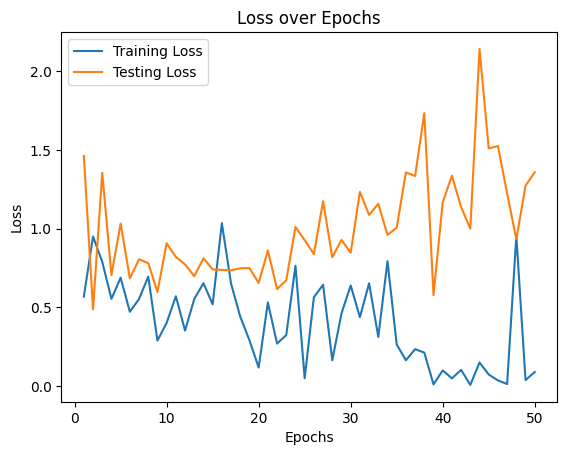

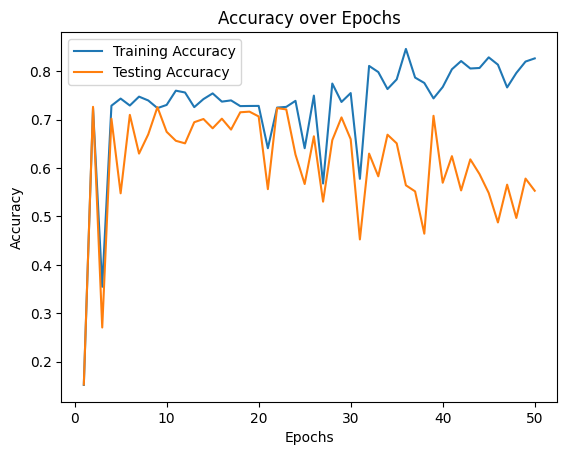

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Define optimizer
optimizer = tf.keras.optimizers.Adam()

epochs = 50

# Define lists to store training and testing metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training and testing loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Training phase
    for images, one_hot_labels in train_dataset:
        with tf.GradientTape() as tape:
            predictions_train = resnet18(images, training=True)
            loss_train = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(one_hot_labels, predictions_train))
        
        gradients_train = tape.gradient(loss_train, resnet18.trainable_variables)
        optimizer.apply_gradients(zip(gradients_train, resnet18.trainable_variables))
    
    # Calculate training accuracy
    total_examples_train = 0
    correct_predictions_train = 0
    for images, one_hot_labels in train_dataset:
        predictions_train = resnet18(images, training=False)
        predicted_labels_train = tf.argmax(predictions_train, axis=1)
        true_labels_train = tf.argmax(one_hot_labels, axis=1)
        correct_predictions_train += tf.reduce_sum(tf.cast(tf.equal(predicted_labels_train, true_labels_train), dtype=tf.float32))
        total_examples_train += images.shape[0]
    
    train_loss = loss_train.numpy()
    train_accuracy = correct_predictions_train / total_examples_train
    print(f"Training Loss - Epoch {epoch+1}: {train_loss}")
    print(f"Training Accuracy - Epoch {epoch+1}: {train_accuracy}")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Testing phase
    true_labels_test_all = []
    predicted_labels_test_all = []
    for images, one_hot_labels in test_dataset:
        predictions_test = resnet18(images, training=False)
        predicted_labels_test = tf.argmax(predictions_test, axis=1)
        true_labels_test = tf.argmax(one_hot_labels, axis=1)
        true_labels_test_all.extend(true_labels_test.numpy())
        predicted_labels_test_all.extend(predicted_labels_test.numpy())
        loss_test = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(one_hot_labels, predictions_test))
    
    # Calculate testing accuracy
    total_examples_test = len(true_labels_test_all)
    correct_predictions_test = sum([1 for true, pred in zip(true_labels_test_all, predicted_labels_test_all) if true == pred])
    test_accuracy = correct_predictions_test / total_examples_test
    print(f"Testing Loss - Epoch {epoch+1}: {loss_test.numpy()}")
    print(f"Testing Accuracy - Epoch {epoch+1}: {test_accuracy}")
    test_losses.append(loss_test.numpy())
    test_accuracies.append(test_accuracy)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(true_labels_test_all, predicted_labels_test_all, average='weighted', zero_division=1)
accuracy = accuracy_score(true_labels_test_all, predicted_labels_test_all)
metrics_dict = {'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'Accuracy': accuracy}
print("Final Evaluation Metrics:")
print(metrics_dict)

# Plotting training and testing loss
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Plotting training and testing accuracy
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


In [27]:
resnet_with_dilation_metrics = [precision, recall, f1, accuracy]